In [12]:
# This script illustrates how to compute and visualize additional performance measures. 

%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

sklearn.metrics
from sklearn import svm, datasets, cross_validation
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc

# import some data to play with
iris = datasets.load_iris()
X, y = iris.data,  iris.target
X, y, iris.target_names = X[y != 2], y[y != 2], ['setosa', 'versicolor',]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

Confusion matrix, without normalization
[[13  0]
 [ 0 12]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


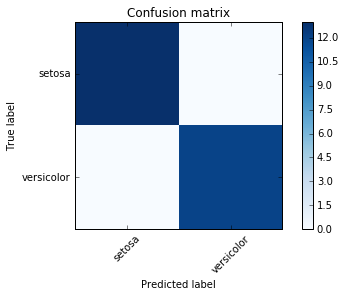

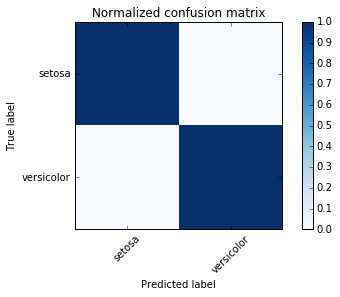

In [13]:
# Run the classifier using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

# The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). 
# This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.

plt.show()

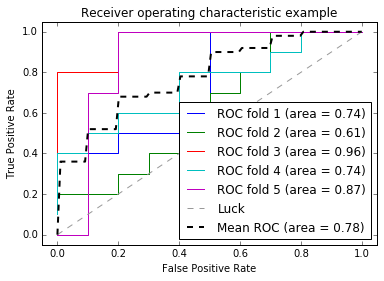

In [14]:
## Classification and ROC analysis

folds = 5

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y, n_folds=folds)
# The code to split data in train and test sets might be tedious to write. 
# Scikit-learn exposes cross-validation generators to generate list of indices for this purpose

# There are several cross validation generators. Here are the main examples: 
# KFold(n, k): Split it K folds, train on K-1 and then test on left-out
# StratifiedKFold(y, k): It preserves the class ratios / label distribution within each fold.
# LeaveOneOut(n): Leave one observation out
# LeaveOneLabelOut(labels): Takes a label array to group observations


classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
precision, recall, average_precision = [], [], []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute Receiver operating characteristic (ROC) curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    # Note: this implementation is restricted to the binary classification task.
    
    # interpolate all ROC curves at this points
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    # Computes Area Under the Curve (AUC) using the trapezoidal rule
    roc_auc = auc(fpr, tpr)
    # This is a general function, given points on a curve. For computing the area under the ROC-curve, see also roc_auc_score
    
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
    # Compute Precision-Recall
    precision_score, recall_score, _ = precision_recall_curve(y[test], probas_[:, 1])
    # Computes precision-recall pairs for different probability thresholds
    # Note: this implementation is restricted to the binary classification task.
    # The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. This
    # ensures that the graph starts on the x axis.
    precision.append(precision_score)
    recall.append(recall_score)
    average_precision.append( average_precision_score(y[test], probas_[:, 1]) )
    # computes the average precision (AP) from prediction scores. 
    # This score corresponds to the area under the precision-recall curve

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

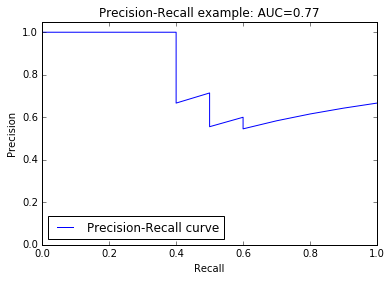

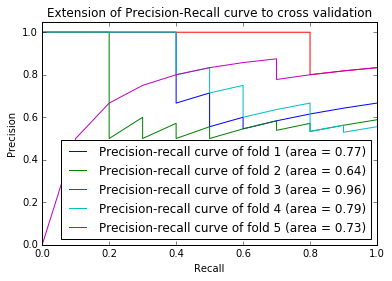

In [15]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()


# Plot Precision-Recall curve for each fold
plt.clf()
for i in range(folds):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of fold {0} (area = {1:0.2f})'
                   ''.format(i+1, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to cross validation')
plt.legend(loc="lower right")
plt.show()


In [20]:
## Plotting Learning Curves

# A learning curve shows the validation and training score of an estimator for varying numbers of training samples. 
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
# If both the validation score and the training score converge to a value that is too low with increasing size of the training set, 
# we will not benefit much from more training data. 

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [21]:
# import some data to play with
digits = datasets.load_digits()
X, y = digits.data, digits.target

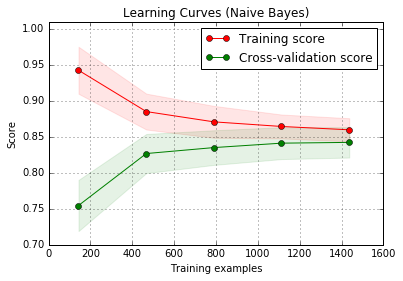

In [22]:
from sklearn.naive_bayes import GaussianNB

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
# On the plot above, the learning curve of a naive Bayes classifier is shown for the digits dataset. 
# Note that the training score and the cross-validation score are both not very good at the end. 

# However, the shape of the curve can be found in more complex datasets very often: 
# the training score is very high at the beginning and decreases and 
# the cross-validation score is very low at the beginning and increases.

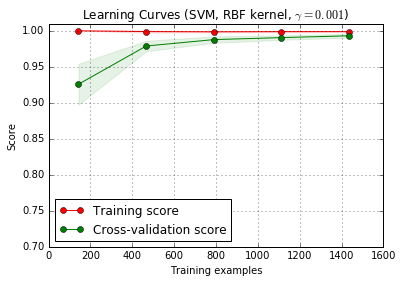

In [23]:
from sklearn.svm import SVC

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
# On the last plot, we see the learning curve of an SVM with RBF kernel. 
# We can see clearly that the training score is still around the maximum 
# and the validation score could be increased with more training samples.